### Fonterra Milk Loss Outlier Detection Problem

In this notebook, we build an algorithm to determine when the operators should be investigating whether the losses are higher than normal. 

Interviewee: Pascal Eun Sig Cheon

#### Step 1. Import libraries

In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split

#### Step 2. Import and preprocess data

##### Substep 2.1 Import data and check data quality

In [49]:
df_milk_flow = pd.read_csv("./interview_data.csv")
df_milk_flow.head()

,timestamp,normalised_losses,normalised_flow
0,2022-08-01 00:00:00+00:00,0.287584,0.000147
1,2022-08-01 00:01:00+00:00,0.287448,0.000235
2,2022-08-01 00:02:00+00:00,0.287205,0.000147
3,2022-08-01 00:03:00+00:00,0.287433,0.000147
4,2022-08-01 00:04:00+00:00,0.287271,0.000147


In [50]:
df_milk_flow.describe()

,normalised_losses,normalised_flow
count,493921.000000,456869.000000
mean,0.318404,0.106595
std,0.140393,0.148560
min,0.000000,0.000000
25%,0.281995,0.000147
50%,0.288304,0.000404
75%,0.293227,0.177511
max,1.000000,1.000000


Let us create following columns: 
- Date: to carry out daily analysis
- Year-Month: to understand the behaviour over a year
- Time of day: to understand the behaviour over a day
- Isnan: boolean column for if either losses or flow column is NaN

In [51]:
df_milk_flow['date'] = df_milk_flow['timestamp'].str[:10]
df_milk_flow['month'] = df_milk_flow['timestamp'].str[:7]
df_milk_flow['time'] = df_milk_flow['timestamp'].str[11:16]
df_milk_flow['isnan'] = (df_milk_flow['normalised_losses'].isna()) | (df_milk_flow['normalised_flow'].isna()) 
df_milk_flow.head()

,timestamp,normalised_losses,normalised_flow,date,month,time,isnan
0,2022-08-01 00:00:00+00:00,0.287584,0.000147,2022-08-01,2022-08,00:00,False
1,2022-08-01 00:01:00+00:00,0.287448,0.000235,2022-08-01,2022-08,00:01,False
2,2022-08-01 00:02:00+00:00,0.287205,0.000147,2022-08-01,2022-08,00:02,False
3,2022-08-01 00:03:00+00:00,0.287433,0.000147,2022-08-01,2022-08,00:03,False
4,2022-08-01 00:04:00+00:00,0.287271,0.000147,2022-08-01,2022-08,00:04,False


In [52]:
print(f"""
The min date is: {df_milk_flow['date'].min()}. The max date is: {df_milk_flow['date'].max()}. 
There should be 351 dates between and including the two dates and we have {df_milk_flow['date'].nunique()}.
In the "losses" column, there are {df_milk_flow['normalised_losses'].isna().sum()} NaNs. 
In the "flow" column, there are {df_milk_flow['normalised_flow'].isna().sum()} NaNs. 
There are {(df_milk_flow['isnan'] == 1).sum()} out of {df_milk_flow.shape[0]} rows in which there are NaNs. That is {round((df_milk_flow['isnan'] == 1).sum() / df_milk_flow.shape[0] * 100, 2)}%.
""")


The min date is: 2022-08-01. The max date is: 2023-07-17. 
There should be 351 dates between and including the two dates and we have 347.
In the "losses" column, there are 158 NaNs. 
In the "flow" column, there are 37210 NaNs. 
There are 37368 out of 494079 rows in which there are NaNs. That is 7.56%.



Since we are getting a data point every minute there should be 1440 (= 60 * 24) rows per day. Below table shows the number of rows for the corresponding date ordered by ascending number of rows. We see that there are some days with missing rows.

In [53]:
df_milk_flow.groupby('date', as_index = False)['date'].count().sort_values(by = 'date', ascending = True).head()

,date
346,32
340,207
336,361
323,491
339,1151


Below table shows the number of rows with NaNs in either the losses or the flow columns in the descending order. 

In [54]:
df_milk_flow.groupby('date', as_index = False)['isnan'].sum().sort_values(by = 'isnan', ascending = False).head()

,date,isnan
338,2023-07-06,693
335,2023-07-03,686
313,2023-06-10,666
334,2023-07-02,644
316,2023-06-14,620


Below table shows the number of rows with NaNs in either the losses or the flow columns for each month in the descending order. There is a clear increase in the number of NaNs going into 2023. 

In [55]:
df_milk_flow.groupby('month', as_index = False)['isnan'].sum().sort_values(by = 'isnan', ascending = False)

,month,isnan
10,2023-06,9141
7,2023-03,6311
9,2023-05,5803
6,2023-02,5753
8,2023-04,4517
11,2023-07,4114
5,2023-01,1722
3,2022-11,5
2,2022-10,2
0,2022-08,0


##### Substep 2.2 Decide what to do with the NaNs

There are only few rows with NaNs in the losses column so it should not affect our analysis if we excluded those rows. However, there are many rows with NaNs in the flow column so in this section we investigate those a bit more.

From my understanding, the flow comes from the amount of water that is used to clean the equipment. This means that the flow is controlled, rather than being purely observed. Below is the histogram of the flows. We see that there is a strong suggestion on the typical amount of flow that is used in the cleaning so we fill out the NaN flows with the mean of the flows.  

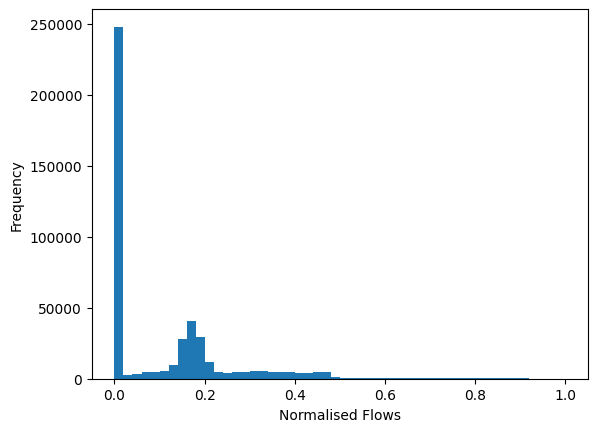

In [56]:
plt.hist(df_milk_flow['normalised_flow'], bins = 50)
plt.xlabel('Normalised Flows')
plt.ylabel('Frequency')
plt.show()

In [57]:
df_milk_flow.loc[df_milk_flow['normalised_flow'].isna(), 'normalised_flow'] = df_milk_flow['normalised_flow'].mean()
df_milk_flow = df_milk_flow[df_milk_flow['normalised_losses'].notnull()]

#### Step 3. Feature engineering and defining daily measure

##### Substep 3.1 Feature engineering

Below scatter plot shows the relationship between the flow and losses. I thought there might be some sort of inverse proportional relationship, but the plot suggests that there isn't any strong relationship. Thus, we define a new variable "Wastage" to represent how much milk has been wasted down the drain, computed by (flow * loss).

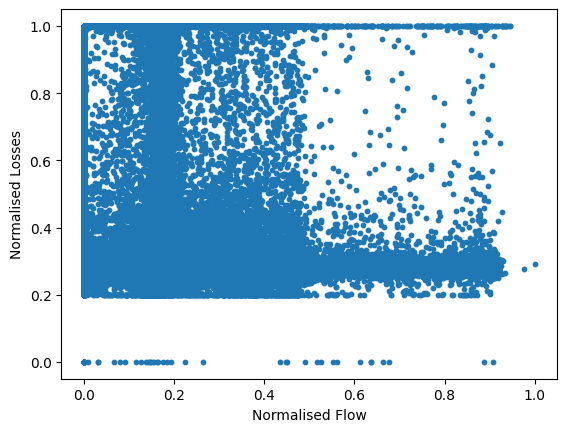

In [58]:
plt.scatter(df_milk_flow['normalised_flow'], df_milk_flow['normalised_losses'], s = 10)
plt.xlabel('Normalised Flow')
plt.ylabel('Normalised Losses')
plt.show()

In [59]:
df_milk_flow['wastage'] = df_milk_flow['normalised_losses'] * df_milk_flow['normalised_flow'] 

Since we want to determine whether the site is losing more milk down the drain than normal at the daily level, we need to define a measure for the "daily wastage". We consider two options:
- Daily sum of wastage: we would have to exclude the dates with missing rows to use this measure
- Daily mean of wastage: can still use those dates with missing rows as long as the wastage remains mostly constant throughout the day (e.g., the wastage in the afternoon isn't usually much greater than during the morning or anything like that) 

Below is the mean of the wastage for each minute of the day. We see that the plot suggests that the wastage usually increases towards the end of the day. However, given that there are not that many days with missing rows, we will include these dates in our analysis and use the mean as the daily wastage measure. 

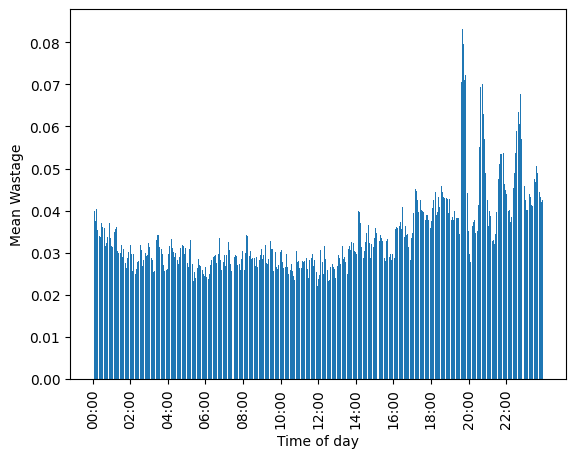

In [60]:
temp_gb_time = df_milk_flow.groupby('time', as_index = False)['wastage'].mean()
plt.bar(temp_gb_time['time'], temp_gb_time['wastage'])
plt.xticks(range(0, len(temp_gb_time['time']), 120), temp_gb_time['time'][::120], rotation = 90)
plt.xlabel('Time of day')
plt.ylabel('Mean Wastage')
plt.show()

##### Substep 3.2 Compute the daily wastage mean

In [61]:
df_milk_flow_daily = df_milk_flow.groupby('date', as_index = False)['wastage'].mean()
df_milk_flow_daily.head()

,date,wastage
0,2022-08-01,0.018675
1,2022-08-02,0.018632
2,2022-08-03,0.046187
3,2022-08-04,0.036104
4,2022-08-05,0.037230


#### Step 4. Anomaly detection using the Z-score analysis

One way to detect data points that lie outside the expected region is by the z-score analysis. Formally, the "Z-score" is defined by the $Z \coloneqq \frac{x - \mu}{\sigma}$ where $\mu$ and $\sigma$ are the mean and standard deviation of a dataset, respectively. In other words, the z-score is a measure of how far away an observed value $x$ is from the mean $\mu$.

In this section, we train the model parameters $\mu$ and $\sigma$ in two ways (1) using the whole dataset as the training set and the testing set (2) separating out the dataset into a training and a testing set.

##### Substep 4.1 Using the whole set

Given the physical context of the problem, it is impossible for the wastage to be negative. Thus, we log transform the wastage and the modelling is carried out over the transformed variable.

In [62]:
df_milk_flow_daily['log_wastage'] = np.log(df_milk_flow_daily['wastage'])

In [63]:
df_milk_flow_daily_analysis1 = df_milk_flow_daily

modelvar_mu_analysis1 = df_milk_flow_daily_analysis1['log_wastage'].mean()
modelvar_sd_analysis1 = df_milk_flow_daily_analysis1['log_wastage'].std()

Now we compute the z-score based on the modelled variables and highlight the days in which the wastage is more than normal based on this approach and selected variable. 

In [64]:
modelvar_threshold_analysis1 = 0.5
df_milk_flow_daily_analysis1['z_score'] = (df_milk_flow_daily_analysis1['log_wastage'] - modelvar_mu_analysis1) / modelvar_sd_analysis1
df_milk_flow_daily_analysis1[(df_milk_flow_daily_analysis1['z_score'] >= modelvar_threshold_analysis1)].sort_values(by = 'z_score', ascending = False).head()

,date,wastage,log_wastage,z_score
138,2022-12-17,0.087360,-2.437721,1.655036
134,2022-12-13,0.085363,-2.460848,1.619975
141,2022-12-20,0.082441,-2.495667,1.567189
142,2022-12-21,0.080369,-2.521122,1.528599
139,2022-12-18,0.078302,-2.547179,1.489095


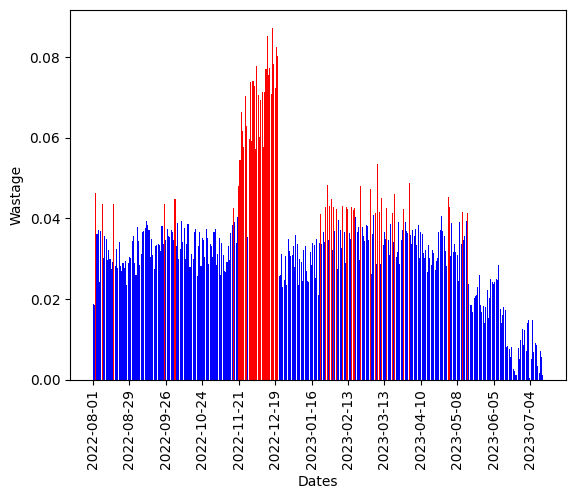

In [65]:
df_milk_flow_daily_analysis1['colors'] = 'blue'
df_milk_flow_daily_analysis1.loc[(df_milk_flow_daily_analysis1['z_score'] >= modelvar_threshold_analysis1), 'colors'] = 'red'
plt.bar(df_milk_flow_daily_analysis1['date'], df_milk_flow_daily_analysis1['wastage'], color = df_milk_flow_daily_analysis1['colors'])
plt.xticks(range(0, len(df_milk_flow_daily_analysis1['date']), 28), df_milk_flow_daily_analysis1['date'][::28], rotation = 90)
plt.xlabel('Dates')
plt.ylabel('Wastage')
plt.show()

Adjusting the tolerance threshold, we can calibrate our model to be more or less sensitivie. In the bar plot below, I have turned up the threshold making the model less sensitive.

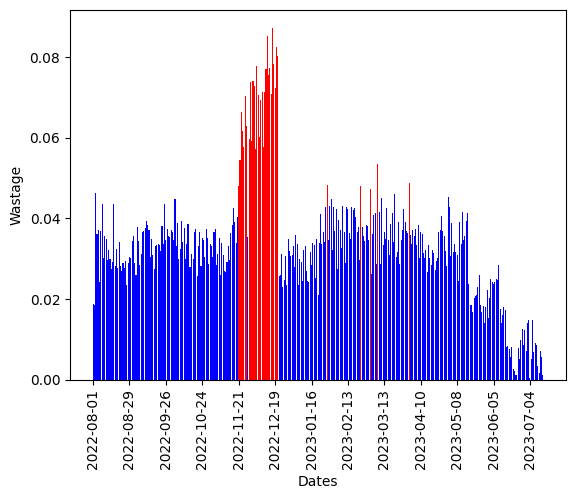

In [66]:
modelvar_threshold_analysis1 = 0.7
df_milk_flow_daily_analysis1['colors'] = 'blue'
df_milk_flow_daily_analysis1.loc[(df_milk_flow_daily_analysis1['z_score'] >= modelvar_threshold_analysis1), 'colors'] = 'red'
plt.bar(df_milk_flow_daily_analysis1['date'], df_milk_flow_daily_analysis1['wastage'], color=df_milk_flow_daily_analysis1['colors'])
plt.xticks(range(0, len(df_milk_flow_daily_analysis1['date']), 28), df_milk_flow_daily_analysis1['date'][::28], rotation = 90)
plt.xlabel('Dates')
plt.ylabel('Wastage')
plt.show()

##### Substep 4.2 Splitting to training/testing sets

We carry out the same analysis as in Substep 4.1, but we randomly split out our dataset into a training set and a testing set. Again the table and the plot below highlight the days in which the wastages are more than normal for the given threshold.

In [67]:
df_milk_flow_daily_analysis2_train, df_milk_flow_daily_analysis2_test = train_test_split(df_milk_flow_daily, test_size = 0.3)

In [68]:
modelvar_mu_analysis2 = df_milk_flow_daily_analysis2_train['log_wastage'].mean()
modelvar_sd_analysis2 = df_milk_flow_daily_analysis2_train['log_wastage'].std()

In [69]:
df_milk_flow_daily_analysis2_test['z_score'] = (df_milk_flow_daily_analysis2_test['log_wastage'] - modelvar_mu_analysis2) / modelvar_sd_analysis2
df_milk_flow_daily_analysis2_test[(df_milk_flow_daily_analysis2_test['z_score'] >= 0.7)].sort_values(by = 'z_score', ascending = False).head()

,date,wastage,log_wastage,z_score,colors
138,2022-12-17,0.087360,-2.437721,1.687527,red
136,2022-12-15,0.077212,-2.561198,1.493125,red
135,2022-12-14,0.075608,-2.582193,1.460071,red
140,2022-12-19,0.072390,-2.625690,1.391590,red
137,2022-12-16,0.070817,-2.647660,1.356999,red


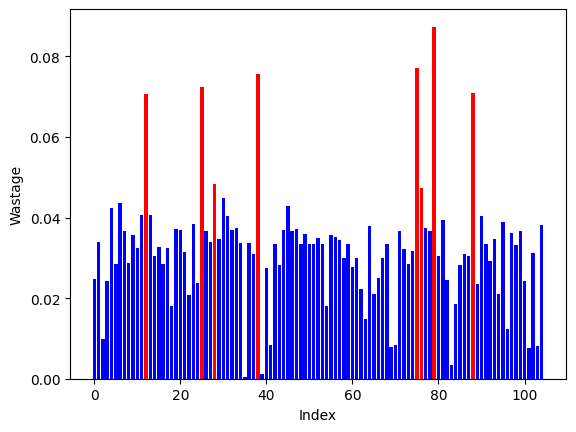

In [70]:
modelvar_threshold_analysis2 = 0.7
df_milk_flow_daily_analysis2_test['colors'] = 'blue'
df_milk_flow_daily_analysis2_test.loc[(df_milk_flow_daily_analysis2_test['z_score'] >= modelvar_threshold_analysis2), 'colors'] = 'red'
plt.bar(range(len(df_milk_flow_daily_analysis2_test['date'])), df_milk_flow_daily_analysis2_test['wastage'], color = df_milk_flow_daily_analysis2_test['colors'])
plt.xlabel('Index')
plt.ylabel('Wastage')
plt.show()

#### Step 5. Conclusions and discussions

##### Conclusions

The goal of the task was to apply an algorithm to determine when the site is losing more milk down the drain than normal at the daily level. For this, we defined the measure to be the daily mean of the wastage (flow * murkiness). From this, we computed the mean and standard deviation of the daily mean wastage and therefore computed the z-scores. Using the z-scores, we demonstreated determining when the site is losing more milk than normal for a specified threshold which can be calibrated depending on how "sensitive" we want our sensor to be. We applied this approach using the whole dataset available as well as separating out the dataset into a training and a testing set.

##### Alternatvie approaches

1. Kalman filter: the Kalman filter algorithm is a real-time sequential estimator of which the computed estimate is the "best" estimate based on the measurements up to that point. Using this, we could compute the wastage forecast and the associated mean and standard deviation. Then, the sensor could be alarmed if the wastage of that day exceeded the upper limit of a confidence we set (say mean + 2 * std). There are several advantages to this approach (1) it is a sequential estimator so the computation of the forecast is efficient, (2) if we wanted more dense estimates (say we wanted to compute the wastage forecast estimates every minute), the modification of the model to allow this could be done efficiently, and (3) if we wanted to look at historical wastage but there were gaps due to equipment malfunction, we could easily reconstruct these using the state space formalism on which the Kalman filter algorithm is based on.    

2. The methods I have discussed so far are from the top of my head. Given more time and resources, I would have looked into other methods to detect anomalies, either consulting my teammates or researching on my own. A quick search on Chat-GPT reveals "isolation forest", "local outlier factor", and "autoencoders" as potential starting points.  

##### Future work

1. We carried out the analysis, using data over the entire available period (Aug 2022 - July 2023). It would be worth investigating if the wastage could be dependent on time. For example, would there be less wastage on average outside the milk production season? If the wastage was strongly time dependent, we may need to implement an approach that caters this for more accuracy.

2. Test out with different approaches to deal with the missing data. e.g., interpolation. Although I suspect that this would not change the analysis much with the given dataset, it may be useful in future proofing as the sesor goes live and is calibrated periodically.

3. We carried out the analysis with the mean wastage as the daily wastage measure. Test out using the sum as the measure. Similar to Point Number 2. Investigating this approach may be useful if we ended up seeing big fluctuations of the wastage over a day. 

##### Further questions and information

1. In this analysis, we used (flow x murkiness) as the wastage model. Is there a standard accepted model for this? It could be good to consult a chemical engineer perhaps. This may impact the outcome of the analysis.

2. There are a few data points with flow = 0. Is this a data quality issue or just rounded down? In this analysis, I treated as them being rounded down.

##### Data quality issues to investigate

1. We saw that the number of NaNs increase suddenly in 2023. It would be good to investigate why this happened and prevent it from happening again.

2. There are some missing days in the data. It would be good to understand that so we can prevent that from happening again.

3. There are a few dates with missing rows. It would be good to understand why this is happening.